In [ ]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from FleetRL.fleet_env.fleet_environment import FleetEnv

if __name__ == "__main__":
#if True:
    # define parameters here for easier change
    n_steps = 8600
    n_episodes = 1
    n_evs = 1
    n_envs = 1

    # make env for the agent
    eval_vec_env = make_vec_env(FleetEnv,
                                n_envs=n_envs,
                                vec_env_cls=SubprocVecEnv,
                                seed=0,
                                env_kwargs={
                                    "schedule_name": "ut_sched_single_eval.csv",
                                    "building_name": "load_ut.csv",
                                    "price_name": "spot_2021_new.csv",
                                    "tariff_name": "fixed_feed_in.csv",
                                    "use_case": "ut",
                                    "include_building": True,
                                    "include_pv": True,
                                    "time_picker": "static",
                                    "deg_emp": False,
                                    "include_price": True,
                                    "ignore_price_reward": False,
                                    "ignore_invalid_penalty": False,
                                    "ignore_overcharging_penalty": False,
                                    "ignore_overloading_penalty": False,
                                    "episode_length": n_steps,
                                    "normalize_in_env": False,
                                    "verbose": 0,
                                    "aux": True,
                                    "log_data": True,
                                    "calculate_degradation": True,
                                    "spot_markup": 10,
                                    "spot_mul": 1.5,
                                    "feed_in_ded": 0.25
                                })
    # %%
    eval_norm_vec_env = VecNormalize(venv=eval_vec_env,
                                     norm_obs=True,
                                     norm_reward=True,
                                     training=True,
                                     clip_reward=10.0)

    dumb_vec_env = make_vec_env(FleetEnv,
                                n_envs=n_envs,
                                vec_env_cls=SubprocVecEnv,
                                seed=0,
                                env_kwargs={
                                    "schedule_name": "ut_sched_single_eval.csv",
                                    "building_name": "load_ut.csv",
                                    "price_name": "spot_2021_new.csv",
                                    "tariff_name": "fixed_feed_in.csv",
                                    "use_case": "ut",
                                    "include_building": True,
                                    "include_pv": True,
                                    "time_picker": "static",
                                    "deg_emp": False,
                                    "include_price": True,
                                    "ignore_price_reward": False,
                                    "ignore_invalid_penalty": False,
                                    "ignore_overcharging_penalty": False,
                                    "ignore_overloading_penalty": False,
                                    "episode_length": n_steps,
                                    "normalize_in_env": False,
                                    "verbose": 0,
                                    "aux": True,
                                    "log_data": True,
                                    "calculate_degradation": True,
                                    "spot_markup": 10,
                                    "spot_mul": 1.5,
                                    "feed_in_ded": 0.25
                                })
    # %%
    dumb_norm_vec_env = VecNormalize(venv=dumb_vec_env,
                                     norm_obs=True,
                                     norm_reward=True,
                                     training=True,
                                     clip_reward=10.0)

    # %%
    eval_norm_vec_env.load(load_path="./tmp/vec_PPO/vec_normalize-UT_2021_realistic_PPO.pkl", venv=eval_norm_vec_env)
    model = PPO.load("./tmp/vec_PPO/PPO-fleet_UT_2021_realistic_PPO.zip", env = eval_norm_vec_env,
                    custom_objects={"observation_space": eval_norm_vec_env.observation_space,
                                   "action_space": eval_norm_vec_env.action_space})

    #len = len(model.observation_space.low)
    #model.observation_space.low = np.full(len, -np.inf)
    #model.observation_space.high = np.full(len, np.inf)
    #model.env = eval_norm_vec_env

    # %%
    mean_reward, _ = evaluate_policy(model, eval_norm_vec_env, n_eval_episodes=n_episodes, deterministic=True)
    print(mean_reward)

    # %%
    log_RL = model.env.env_method("get_log")[0]
    rl_start_time = model.env.env_method("get_start_time")[0]
    dumb_norm_vec_env.env_method("set_start_time", rl_start_time)
    # %%
    print("################################################################")

    episode_length = n_steps
    timesteps_per_hour = 4
    n_episodes = n_episodes
    dumb_norm_vec_env.reset()

    for i in range(episode_length * timesteps_per_hour * n_episodes):
        if dumb_norm_vec_env.env_method("is_done")[0]:
            dumb_norm_vec_env.reset()
        dumb_norm_vec_env.step([np.ones(n_evs)])

    dumb_log = dumb_norm_vec_env.env_method("get_log")[0]

    log_RL.reset_index(drop=True, inplace=True)
    log_RL = log_RL.iloc[0:-2]
    dumb_log.reset_index(drop=True, inplace=True)
    dumb_log = dumb_log.iloc[0:-2]

    rl_cashflow = log_RL["Cashflow"].sum()
    rl_reward = log_RL["Reward"].sum()
    rl_deg = log_RL["Degradation"].sum()
    rl_overloading = log_RL["Grid overloading"].sum()
    rl_soc_violation = log_RL["SOC violation"].sum()
    rl_n_violations = log_RL[log_RL["SOC violation"] > 0]["SOC violation"].size
    rl_soh = log_RL["SOH"].iloc[-1]

    dumb_cashflow = dumb_log["Cashflow"].sum()
    dumb_reward = dumb_log["Reward"].sum()
    dumb_deg = dumb_log["Degradation"].sum()
    dumb_overloading = dumb_log["Grid overloading"].sum()
    dumb_soc_violation = dumb_log["SOC violation"].sum()
    dumb_n_violations = dumb_log[dumb_log["SOC violation"] > 0]["SOC violation"].size
    dumb_soh = dumb_log["SOH"].iloc[-1]

    print(f"RL reward: {rl_reward}")
    print(f"DC reward: {dumb_reward}")
    print(f"RL cashflow: {rl_cashflow}")
    print(f"DC cashflow: {dumb_cashflow}")

    total_results = pd.DataFrame()
    total_results["Category"] = ["Reward", "Cashflow", "Average degradation per EV", "Overloading", "SOC violation", "# Violations", "SOH"]

    total_results["RL-based charging"] = [rl_reward,
                                          rl_cashflow,
                                          np.round(np.mean(rl_deg), 5),
                                          rl_overloading,
                                          rl_soc_violation,
                                          rl_n_violations,
                                          np.round(np.mean(rl_soh), 5)]

    total_results["Dumb charging"] = [dumb_reward,
                                      dumb_cashflow,
                                      np.round(np.mean(dumb_deg), 5),
                                      dumb_overloading,
                                      dumb_soc_violation,
                                      dumb_n_violations,
                                      np.round(np.mean(dumb_soh), 5)]

    print(total_results)


    # real charging power sent
    real_power_rl = []
    for i in range(log_RL.__len__()):
        log_RL.loc[i, "hour_id"] = (log_RL.loc[i, "Time"].hour + log_RL.loc[i, "Time"].minute / 60)
        # real_power_rl.append({"real_power": (log_RL.loc[i, "Action"]
        #                                      * log_RL.loc[i, "Observation"][2 * n_evs + 19:2 * n_evs + 19 + n_evs]
        #                                      * log_RL.loc[i, "Observation"][-4])})

    #log_RL = pd.concat((log_RL, pd.DataFrame(real_power_rl)), axis=1)

    real_power_dumb = []
    for i in range(dumb_log.__len__()):
        dumb_log.loc[i, "hour_id"] = (dumb_log.loc[i, "Time"].hour + dumb_log.loc[i, "Time"].minute / 60)
        # real_power_dumb.append({"real_power": (dumb_log.loc[i, "Action"]
        #                                        * dumb_log.loc[i, "Observation"][2 * n_evs + 19:2 * n_evs + 19 + n_evs]
        #                                        * dumb_log.loc[i, "Observation"][4 * n_evs + 19:4 * n_evs + 19 + n_evs]
        #                                        * dumb_log.loc[i, "Observation"][-4])})

    #dumb_log = pd.concat((dumb_log, pd.DataFrame(real_power_dumb)), axis=1)

    mean_per_hid_rl = log_RL.groupby("hour_id").mean()["Charging energy"].reset_index(drop=True)
    mean_all_rl = []
    for i in range(mean_per_hid_rl.__len__()):
        mean_all_rl.append(np.mean(mean_per_hid_rl[i]))

    mean_per_hid_dumb = dumb_log.groupby("hour_id").mean()["Charging energy"].reset_index(drop=True)
    mean_all_dumb = []
    for i in range(mean_per_hid_dumb.__len__()):
        mean_all_dumb.append(np.mean(mean_per_hid_dumb[i]))

    mean_both = pd.DataFrame()
    mean_both["RL"] = np.multiply(mean_all_rl, 4)
    mean_both["Dumb charging"] = np.multiply(mean_all_dumb, 4)

    mean_both.plot()

    plt.xticks([0,8,16,24,32,40,48,56,64,72,80,88]
               ,["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00"],
               rotation=45)

    plt.legend()
    plt.grid(alpha=0.2)

    plt.ylabel("Charging power in kW")
    max = log_RL.loc[0, "Observation"][-10]
    plt.ylim([-max * 1.2, max * 1.2])

    plt.show()

In [ ]:
    mean_both.plot()

    plt.xticks([0,8,16,24,32,40,48,56,64,72,80,88]
               ,["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00"],
               rotation=45)

    plt.legend()
    plt.grid(alpha=0.2)

    plt.ylabel("Charging power in kW")
    max = log_RL.loc[0, "Observation"][-10]
    plt.ylim([-5,5])

    plt.show()

In [ ]:
    mean_both.plot()

    plt.xticks([0,8,16,24,32,40,48,56,64,72,80,88]
               ,["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00"],
               rotation=45)

    plt.legend()
    plt.grid(alpha=0.2)

    plt.ylabel("Charging power in kW")
    max = log_RL.loc[0, "Observation"][-10]
    plt.ylim([-max * 1.2, max * 1.2])
    #plt.savefig("PPO_ut_real_single_vast_jul19.pdf")

    plt.show()
    
    print(total_results)

In [ ]:
import pandas as pd
import matplotlib.dates as mdates


# Create a date range from Jan to Dec
# Create a date range from Jan to Dec with a 15-minute resolution
date_range = pd.date_range(start="2023-01-01", end="2023-12-31", freq='15min')

# Check if the lengths match
print(len(date_range) == len(log_RL))  # should print True

# Continue with the rest of the code...

# Create a figure
fig, ax = plt.subplots()

# Rescale the index of the dataframes to match the date range
rescaled_log_RL = log_RL.copy()
rescaled_log_RL.index = date_range[:len(log_RL)]
rescaled_dumb_log = dumb_log.copy()
rescaled_dumb_log.index = date_range[:len(dumb_log)]

# Plot the data
ax.plot(rescaled_dumb_log.index, rescaled_dumb_log['SOH'], label='Dumb', color='red')
ax.plot(rescaled_log_RL.index, rescaled_log_RL['SOH'], label='RL', color='blue')


# Set the title and labels
ax.set_title('State of Health Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('State of Health')
ax.legend()

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_xticklabels(ax.get_xticklabels()[0:12])[0:12]
ax.set_xticks(ax.get_xticks()[0:12])[0:12]
# Show the plot
plt.grid(alpha=0.2)
plt.savefig("PPO_ut_real_single_vast_jul19_SOH.pdf")

plt.show()


In [ ]:
fig, axs = plt.subplots(1,1, figsize=(3,3))

# Plot RL data
log_RL.loc[log_RL["SOC violation"] > 0, "SOC violation"].sort_values(ascending=False).reset_index(drop=True).plot.bar(color="blue", ax=axs)
axs.set_title("RL-based charging")
axs.set_xticks([0,5,8])
axs.set_ylim([0,0.65])
axs.grid(alpha=0.2)
axs.set_xlabel("Violations")
axs.set_ylabel("Missing SOC per violation")



plt.tight_layout()
plt.savefig("ppo_ut_real_soc_vio_vast_jul19.pdf")
plt.show()



In [ ]:
log_RL['Action'] = log_RL['Action'].apply(lambda x: x[0])
dumb_log['Action'] = dumb_log['Action'].apply(lambda x: x[0])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot the distribution of actions for the RL-based strategy on the first subplot
axs[0].hist(log_RL['Action'], bins=50, color='blue', edgecolor='black')
axs[0].set_title('Distribution of Actions for RL-based Charging')
axs[0].set_xlabel('Action')
axs[0].set_ylabel('Frequency')

# Plot the distribution of actions for the dumb strategy on the second subplot
axs[1].hist(dumb_log['Action'], bins=50, color='red', edgecolor='black')
axs[1].set_title('Distribution of actions for Dumb Charging')
axs[1].set_xlabel('Action')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig("ppo_ut_real_act_dist_vast_jul19.pdf")

plt.show()


In [ ]:
log_RL.to_pickle("PPO_final_ut_real.pickle")

RL reward: -6099.609985543915
DC reward: -5601.494319000379
RL cashflow: -1247.7263367430228
DC cashflow: -1467.6705344879144
                     Category  RL-based charging  Dumb charging
0                      Reward       -6099.609986   -5601.494319
1                    Cashflow       -1247.726337   -1467.670534
2  Average degradation per EV           0.067460       0.069040
3                 Overloading           0.000000     200.868154
4               SOC violation           1.445712       0.000000
5                # Violations           4.000000       0.000000
6                         SOH           0.932540       0.930960


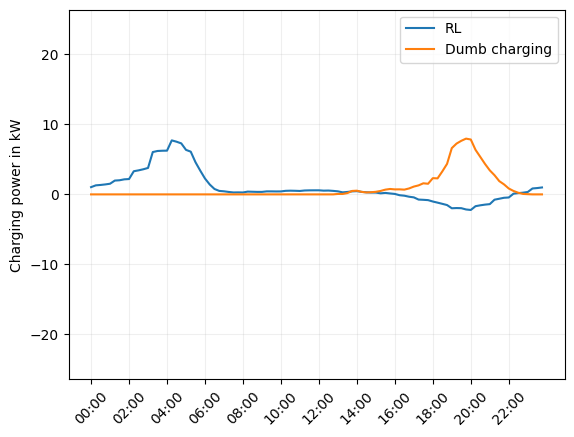

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

log_RL = pd.read_pickle("./PPO_final_ut_real.pickle")
dumb_log = pd.read_pickle("./dumb_ut_real.pickle")

rl_cashflow = log_RL["Cashflow"].sum()
rl_reward = log_RL["Reward"].sum()
rl_deg = log_RL["Degradation"].sum()
rl_overloading = log_RL["Grid overloading"].sum()
rl_soc_violation = log_RL["SOC violation"].sum()
rl_n_violations = log_RL[log_RL["SOC violation"] > 0]["SOC violation"].size
rl_soh = log_RL["SOH"].iloc[-1]

dumb_cashflow = dumb_log["Cashflow"].sum()
dumb_reward = dumb_log["Reward"].sum()
dumb_deg = dumb_log["Degradation"].sum()
dumb_overloading = dumb_log["Grid overloading"].sum()
dumb_soc_violation = dumb_log["SOC violation"].sum()
dumb_n_violations = dumb_log[dumb_log["SOC violation"] > 0]["SOC violation"].size
dumb_soh = dumb_log["SOH"].iloc[-1]

print(f"RL reward: {rl_reward}")
print(f"DC reward: {dumb_reward}")
print(f"RL cashflow: {rl_cashflow}")
print(f"DC cashflow: {dumb_cashflow}")

total_results = pd.DataFrame()
total_results["Category"] = ["Reward", "Cashflow", "Average degradation per EV", "Overloading", "SOC violation", "# Violations", "SOH"]

total_results["RL-based charging"] = [rl_reward,
                                      rl_cashflow,
                                      np.round(np.mean(rl_deg), 5),
                                      rl_overloading,
                                      rl_soc_violation,
                                      rl_n_violations,
                                      np.round(np.mean(rl_soh), 5)]

total_results["Dumb charging"] = [dumb_reward,
                                  dumb_cashflow,
                                  np.round(np.mean(dumb_deg), 5),
                                  dumb_overloading,
                                  dumb_soc_violation,
                                  dumb_n_violations,
                                  np.round(np.mean(dumb_soh), 5)]

print(total_results)


# real charging power sent
real_power_rl = []
for i in range(log_RL.__len__()):
    log_RL.loc[i, "hour_id"] = (log_RL.loc[i, "Time"].hour + log_RL.loc[i, "Time"].minute / 60)
    # real_power_rl.append({"real_power": (log_RL.loc[i, "Action"]
    #                                      * log_RL.loc[i, "Observation"][2 * n_evs + 19:2 * n_evs + 19 + n_evs]
    #                                      * log_RL.loc[i, "Observation"][-4])})

#log_RL = pd.concat((log_RL, pd.DataFrame(real_power_rl)), axis=1)

real_power_dumb = []
for i in range(dumb_log.__len__()):
    dumb_log.loc[i, "hour_id"] = (dumb_log.loc[i, "Time"].hour + dumb_log.loc[i, "Time"].minute / 60)
    # real_power_dumb.append({"real_power": (dumb_log.loc[i, "Action"]
    #                                        * dumb_log.loc[i, "Observation"][2 * n_evs + 19:2 * n_evs + 19 + n_evs]
    #                                        * dumb_log.loc[i, "Observation"][4 * n_evs + 19:4 * n_evs + 19 + n_evs]
    #                                        * dumb_log.loc[i, "Observation"][-4])})

#dumb_log = pd.concat((dumb_log, pd.DataFrame(real_power_dumb)), axis=1)

mean_per_hid_rl = log_RL.groupby("hour_id").mean()["Charging energy"].reset_index(drop=True)
mean_all_rl = []
for i in range(mean_per_hid_rl.__len__()):
    mean_all_rl.append(np.mean(mean_per_hid_rl[i]))

mean_per_hid_dumb = dumb_log.groupby("hour_id").mean()["Charging energy"].reset_index(drop=True)
mean_all_dumb = []
for i in range(mean_per_hid_dumb.__len__()):
    mean_all_dumb.append(np.mean(mean_per_hid_dumb[i]))

mean_both = pd.DataFrame()
mean_both["RL"] = np.multiply(mean_all_rl, 4)
mean_both["Dumb charging"] = np.multiply(mean_all_dumb, 4)

mean_both.plot()

plt.xticks([0,8,16,24,32,40,48,56,64,72,80,88]
           ,["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00"],
           rotation=45)

plt.legend()
plt.grid(alpha=0.2)

plt.ylabel("Charging power in kW")
max = log_RL.loc[0, "Observation"][-10]
plt.ylim([-max * 1.2, max * 1.2])

plt.show()